# Extracting frames for interpreting the policy projection plots

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections.abc import Container
import pickle

In [3]:
def extract_frames(
    datetime: str,
    ep_idxs: Container[int],
    crop_lims: tuple | None = None,
) -> list:
    """
    Extract frames from each episode video.
    """
    frames = []

    for ep_idx in ep_idxs:
        ep_frames = []
        cam = cv2.VideoCapture(
            "../../src/rl_vcf/outputs/"
            + datetime
            + "/videos/rl-video-episode-{ep_idx}.mp4".format(ep_idx=ep_idx)
        )
        while True:
            ret, frame = cam.read()
            if not ret:
                break
            if crop_lims is not None:
                frame = frame[crop_lims[0] : crop_lims[1], crop_lims[2] : crop_lims[3]]
            frame = cv2.cvtColor(frame.astype(np.uint8), cv2.COLOR_BGR2RGB)
            frame = frame.tolist()
            ep_frames.append(frame)

        # For some reason, each video for ep_idx > 0 has 1 extra frame at the start from the end of the previous episode
        if ep_idx > 0:
            ep_frames = ep_frames[1:]

        frames.append(ep_frames)

    cam.release()

    return frames

In [5]:
# Extract frames
alpha_5_frames = extract_frames(
    datetime="2025-01-10/19-09-51",
    ep_idxs=np.arange(0, 1000, 100),
    crop_lims=(0, 200, 0, 200),
)
filename = "extracted_frames.pkl"
with open(filename, "wb") as file:
    pickle.dump(alpha_5_frames, file, pickle.HIGHEST_PROTOCOL)

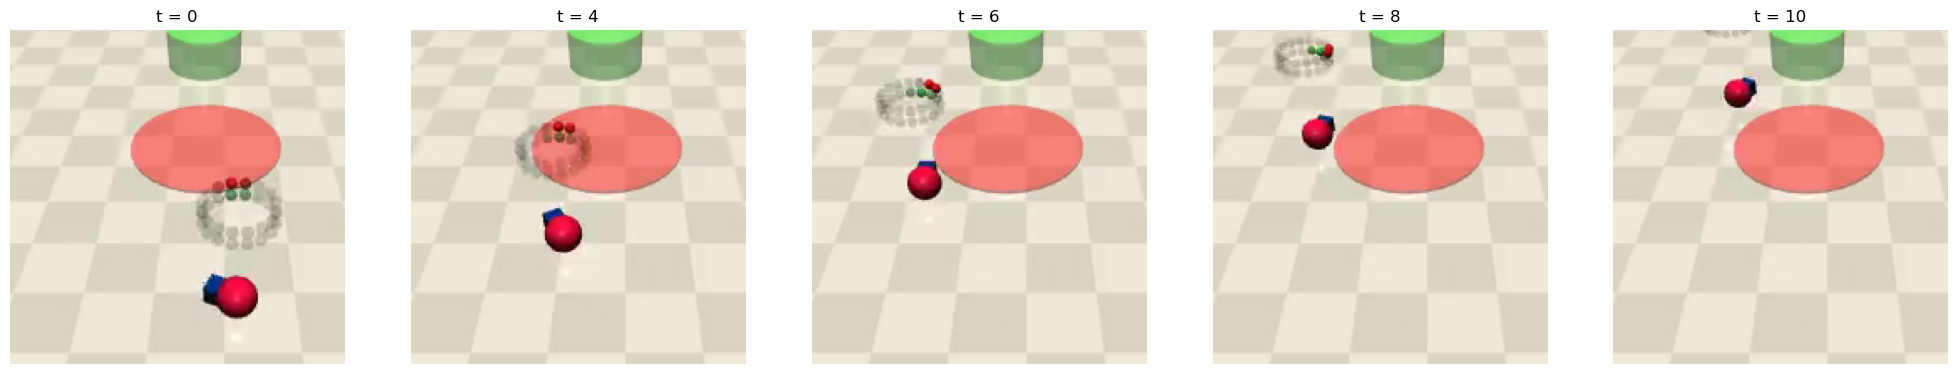

In [9]:
timesteps_to_plot = [0, 4, 6, 8, 10]
fig, axs = plt.subplots(
    1,
    len(timesteps_to_plot),
    figsize=(len(timesteps_to_plot) * 5, 5),
)
for k, idx in enumerate(timesteps_to_plot):
    axs[k].imshow(alpha_5_frames[1][idx])
    axs[k].set_title(f"t = {idx}")
    axs[k].axis("off")
plt.show()